In [1]:
import numpy as np
import torch
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.zeros((3,1)).T.cuda() @ torch.ones((3,1)).cuda()

tensor([[0.]], device='cuda:0')

In [78]:
class VIODataset(Dataset):
    def __init__(self, img_annot_file, data_dir, label_file):
        img_annot_cols=["stamp","name","none"]
        self.img_annot = pd.read_csv(img_annot_file, delimiter=' ', skiprows=1, names=img_annot_cols)
        self.img_annot = self.img_annot.iloc[: , :-1]

        label_cols=["stamp","tx","ty","tz","qx","qy","qz","qw","none"]
        self.labels = pd.read_csv(label_file, delimiter=' ', skiprows=1, names=label_cols)
        self.labels = self.labels.iloc[: , :-1]

        self.img_annot.insert(2,"lAct",0)
        self.img_annot.insert(3,"lPrev",0)
        prev=0
        current=1
        for index, row in self.img_annot.iterrows():
            while self.labels.iloc[current,0]<row["stamp"] and current+1<len(self.labels):
                current+=1
            self.img_annot.at[index,'lAct']=current
            self.img_annot.at[index,'lPrev']=prev
            prev=current

        #Add deltas
        from pyquaternion import Quaternion
        while len(self.labels.columns)<15:
            self.labels.insert(len(self.labels.columns),"d"+self.labels.columns[-7],0)
        self.labels.iloc[0,8:14]=0
        self.labels.iloc[0,14]=1

        for i in range(1,len(self.labels)):
            self.labels.iloc[i,8:11]=self.labels.iloc[i,1:4]-self.labels.iloc[i-1,1:4]
            
            q2=Quaternion(self.labels.iloc[i,[7,4,5,6]])
            q1=Quaternion(self.labels.iloc[i-1,[7,4,5,6]])
            qd=q2*q1.inverse
            q1,q2,qd
            self.labels.iloc[i,11:15]=qd.elements[[1,2,3,0]]

        if len(self.img_annot.columns)<18:
            self.img_annot.insert(4,"tx",0)
            self.img_annot.insert(5,"ty",0)
            self.img_annot.insert(6,"tz",0)
            self.img_annot.insert(7,"qx",0)
            self.img_annot.insert(8,"qy",0)
            self.img_annot.insert(9,"qz",0)
            self.img_annot.insert(10,"qw",1)
            self.img_annot.insert(11,"dtx",0)
            self.img_annot.insert(12,"dty",0)
            self.img_annot.insert(13,"dtz",0)
            self.img_annot.insert(14,"dqx",0)
            self.img_annot.insert(15,"dqy",0)
            self.img_annot.insert(16,"dqz",0)
            self.img_annot.insert(17,"dqw",1)


        for i in range(1,len(self.img_annot)):
            prev=self.img_annot.iloc[i,3]
            current=self.img_annot.iloc[i,2]
            self.img_annot.iloc[i,4:11]=self.labels.iloc[i,1:8]
            self.img_annot.iloc[i,11:18]=self.img_annot.iloc[i,4:11]-self.img_annot.iloc[i-1,4:11]
            
            q2=Quaternion(self.img_annot.iloc[i,[10,7,8,9]])
            q1=Quaternion(self.img_annot.iloc[i-1,[10,7,8,9]])
            qd=q2*q1.inverse
            q1,q2,qd
            self.img_annot.iloc[i,14:18]=qd.elements[[1,2,3,0]]

        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Normalize(mean=[.0], std=[.25]),
        ])

    def __len__(self):
        return len(self.img_annot)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.img_annot.iloc[idx]["name"])
        image = read_image(img_path).float()
        label = torch.tensor(self.labels.iloc[idx][["qx","qy","qz","qw"]].to_numpy(),
                             dtype=torch.float32)
        image = self.transform(image)
        return image, label

In [79]:
data_dir = "indoor_forward_9_snapdragon_with_gt/"
img_annot_cols=["stamp","name","none"]
img_annot = pd.read_csv(data_dir + "left_images.txt", delimiter=' ', skiprows=1, names=img_annot_cols)
img_annot = img_annot.iloc[: , :-1]
stereo_count = len(img_annot)
img_annot, len(img_annot), img_annot.iloc[0]["name"]

(             stamp                  name
 0     1.540823e+09     img/image_0_0.png
 1     1.540823e+09     img/image_0_1.png
 2     1.540823e+09     img/image_0_2.png
 3     1.540823e+09     img/image_0_3.png
 4     1.540823e+09     img/image_0_4.png
 ...            ...                   ...
 2063  1.540823e+09  img/image_0_2063.png
 2064  1.540823e+09  img/image_0_2064.png
 2065  1.540823e+09  img/image_0_2065.png
 2066  1.540823e+09  img/image_0_2066.png
 2067  1.540823e+09  img/image_0_2067.png
 
 [2068 rows x 2 columns],
 2068,
 'img/image_0_0.png')

In [6]:
label_cols=["stamp","tx","ty","tz","qx","qy","qz","qw","none"]
labels = pd.read_csv(data_dir + "groundtruth.txt", delimiter=' ', skiprows=1, names=label_cols)
labels = labels.iloc[: , :-1]
labels.iloc[0][["qx","qy","qz","qw"]], np.linalg.norm(labels.iloc[0][["qx","qy","qz","qw"]].to_numpy())

(qx    0.007125
 qy   -0.005998
 qz    0.890496
 qw   -0.454896
 Name: 0, dtype: float64,
 1.0)

In [80]:
vio_dataset = VIODataset(data_dir + "left_images.txt", data_dir, data_dir + "groundtruth.txt")
vio_dataset.__getitem__(0)

(tensor([[[360., 360., 372.,  ..., 416., 424., 408.],
          [360., 364., 372.,  ..., 412., 428., 408.],
          [360., 364., 368.,  ..., 416., 412., 408.],
          ...,
          [312., 304., 288.,  ..., 372., 372., 352.],
          [308., 304., 292.,  ..., 368., 360., 344.],
          [308., 304., 276.,  ..., 364., 348., 344.]]]),
 tensor([ 0.0071, -0.0060,  0.8905, -0.4549]))

In [11]:
np.linalg.det(np.eye(3))

1.0

In [12]:
import transforms3d

In [13]:
alpha, beta, gamma = 0.123, -1.234, 2.345
origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]
R = transforms3d.euler.euler2mat(alpha, beta, gamma)
np.linalg.det(R) # this could be enforced in loss function ? : )

0.9999999999999998

In [16]:
# R = transforms3d.euler.euler2mat(alpha, beta, gamma)
R = np.random.rand(3,3)
R = torch.tensor(R, requires_grad=True)
Dloss = torch.norm(1 - R.det(),2)
Dloss.backward()

Dloss.item()

0.9548602198631305

In [17]:
np.linalg.norm([0.00712511541035951,-0.00599798947503901,0.890495788939425,-0.45489614939434]) # quaternion sample

1.0

In [14]:
# data_dir = "indoor_forward_9_davis_with_gt/"
# colnames=["stamp","x","y","polarity"]
# my_data = pd.read_csv(data_dir + "events.txt", delimiter=' ', skiprows=1, names=colnames)
# events_count = len(my_data)
# my_data, len(my_data)
# events = my_data[['x','y','polarity']].to_numpy(), events_count/stereo_count, 256*256, events[:int(20e3)].shape

In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # multiple images?
model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True) # inly quaternion
model

HTTPError: HTTP Error 403: rate limit exceeded

In [20]:
input_image = Image.open("indoor_forward_9_snapdragon_with_gt/img/image_0_4.png") # gray scale
(w,h) = input_image.size
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.0], std=[.25]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# # move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

NameError: name 'model' is not defined

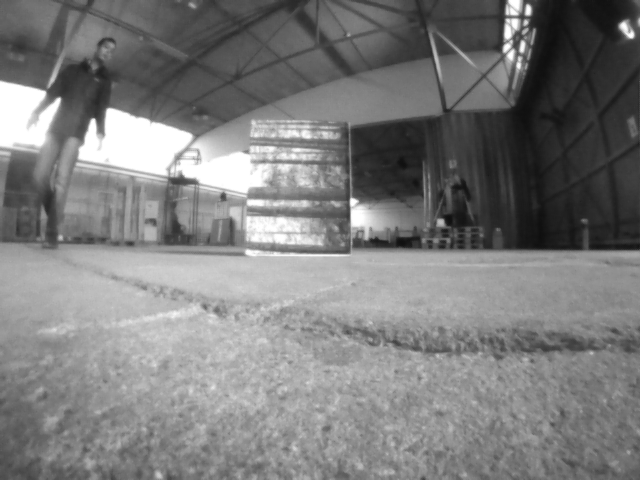

In [21]:
input_image

In [22]:
input_image = Image.open("indoor_forward_9_davis_with_gt/img/image_0_0.png") # gray scale
input_image

FileNotFoundError: [Errno 2] No such file or directory: 'indoor_forward_9_davis_with_gt/img/image_0_0.png'

In [19]:
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=16, shuffle=True, num_workers=8)
next(iter(dataloader))

[tensor([[[[244., 244., 228.,  ..., 432., 432., 432.],
           [244., 244., 224.,  ..., 416., 428., 420.],
           [248., 256., 236.,  ..., 412., 416., 420.],
           ...,
           [436., 432., 456.,  ..., 520., 496., 456.],
           [436., 432., 448.,  ..., 520., 496., 472.],
           [448., 440., 444.,  ..., 516., 500., 476.]]],
 
 
         [[[380., 380., 388.,  ..., 456., 468., 496.],
           [376., 384., 392.,  ..., 448., 472., 484.],
           [380., 376., 384.,  ..., 456., 464., 480.],
           ...,
           [448., 456., 440.,  ..., 424., 428., 412.],
           [444., 452., 436.,  ..., 428., 424., 408.],
           [416., 436., 420.,  ..., 428., 428., 412.]]],
 
 
         [[[328., 328., 288.,  ..., 384., 376., 372.],
           [320., 328., 296.,  ..., 376., 384., 352.],
           [332., 316., 280.,  ..., 364., 388., 384.],
           ...,
           [296., 284., 284.,  ..., 116.,  92., 120.],
           [284., 284., 292.,  ..., 108.,  92.,  96.],
     

In [20]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # for phase in ['train', 'val']:
    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                qnorm = torch.norm(outputs,dim=1) # second part of the loss drives quaternion to be normalized i.e. norm(q) == 1
                loss = criterion(outputs, labels) + criterion(qnorm, torch.ones_like(qnorm))

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(vio_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f}')

Epoch 0/4
----------
train Loss: 0.1358
Epoch 1/4
----------
train Loss: 0.0806
Epoch 2/4
----------
train Loss: 0.0599
Epoch 3/4
----------
train Loss: 0.0419
Epoch 4/4
----------
train Loss: 0.0355


In [31]:
pred = (np.ones((4,1)) - .1) 
pred = pred / np.linalg.norm(pred)
label = pred - .02 # 2e-2 error per example : )
np.linalg.norm(pred-label)

0.040000000000000036